In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import regex
import joblib
import gc
import optuna

import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV 
from sklearn.metrics import accuracy_score, confusion_matrix, mean_absolute_error, classification_report, roc_auc_score, roc_curve, f1_score, precision_recall_curve

## Фильтрация признаков

In [2]:
#Импорт датафрейма, разбиение на train и test
df = pd.read_pickle("data/ga_sessions_prepared.pkl")

df_prepared = df.copy()

x = df_prepared.drop(['event_value'], axis=1)
y = df_prepared['event_value']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [3]:
df_prepared.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1860042 entries, 0 to 1860041
Columns: 162 entries, event_value to visit_season_winter
dtypes: float64(159), int64(3)
memory usage: 2.2 GB


In [4]:
#Инициализация случайного леса
randfor = RandomForestClassifier(n_estimators=100, max_depth=8)
#clf.fit(x_train, y_train)

In [5]:
#Обучение
randfor.fit(x_train, y_train)

RandomForestClassifier(max_depth=8)

In [6]:
#Метрика ROC-AUC
y_proba = randfor.predict_proba(x_test)[:, 1]
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

ROC-AUC: 0.68044353680068


In [7]:
#Важность фич
f_imp_list = list(zip(x_train.columns, randfor.feature_importances_))
f_imp_list.sort(key=lambda x: x[1], reverse=True)
f_imp_list

[('utm_campaign_freq', 0.10837890803865584),
 ('visit_month', 0.09783298179319078),
 ('utm_source_freq', 0.07560619756908965),
 ('visit_number_std', 0.07486784567664632),
 ('utm_adcontent_freq', 0.07057345166434252),
 ('visit_season_spring', 0.05487781011975341),
 ('utm_medium_referral', 0.05014433720495805),
 ('organic_traffic', 0.04984474117565461),
 ('utm_keyword_freq', 0.04123858108614184),
 ('utm_medium_cpm', 0.03250374487658893),
 ('social_ad', 0.021170280296451387),
 ('visit_season_fall', 0.019972633521400867),
 ('screen_size_std', 0.019935761162922533),
 ('utm_medium_cpc', 0.018003741563769195),
 ('visit_day_cos', 0.015737508464095946),
 ('visit_season_summer', 0.014875176016804737),
 ('visit_day_sin', 0.014633025144812876),
 ('visit_season_winter', 0.014343851135421097),
 ('device_os_unknown_os', 0.01361878677347588),
 ('geo_city_freq', 0.013231797014913534),
 ('device_brand_freq', 0.012481110293104804),
 ('utm_medium_(none)', 0.011061789124183184),
 ('visit_hour_cos', 0.00959

Признаки auto_model и auto_brand имеют низку ценность для модели не обладают большим влиянием на предсказательную способность.

In [8]:
#Удаление ненужных колонок
df_prepared = df_prepared.drop(df_prepared.filter(regex="^auto_brand").columns, axis=1)
df_prepared = df_prepared.drop(df_prepared.filter(regex="^auto_model").columns, axis=1)

In [9]:
#Разбиение на train и test
x = df_prepared.drop(['event_value'], axis=1)
y = df_prepared['event_value']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [10]:
#Обучение
randfor.fit(x_train, y_train)

RandomForestClassifier(max_depth=8)

In [11]:
#Метрика ROC-AUC
y_proba_without_auto = randfor.predict_proba(x_test)[:, 1]
print("ROC-AUC:", roc_auc_score(y_test, y_proba_without_auto))

ROC-AUC: 0.6842221132993853


In [12]:
#Важность фич
f_imp_list = list(zip(x_train.columns, randfor.feature_importances_))
f_imp_list.sort(key=lambda x: x[1], reverse=True)
f_imp_list

[('visit_month', 0.10856832248349947),
 ('visit_number_std', 0.08814879978778054),
 ('utm_campaign_freq', 0.0831670976513874),
 ('utm_source_freq', 0.07463472146598385),
 ('utm_adcontent_freq', 0.07415263685292536),
 ('utm_medium_referral', 0.07000012262503637),
 ('organic_traffic', 0.054542798186863146),
 ('visit_season_spring', 0.04892785464199157),
 ('utm_keyword_freq', 0.038356174998502496),
 ('utm_medium_cpm', 0.0328908882775508),
 ('screen_size_std', 0.022603883749775556),
 ('visit_season_fall', 0.018475455702155193),
 ('social_ad', 0.0167924867289689),
 ('visit_day_cos', 0.016670567008736936),
 ('utm_medium_cpc', 0.01659053209692293),
 ('visit_day_sin', 0.0159715200135623),
 ('visit_season_winter', 0.015871651088097773),
 ('geo_city_freq', 0.015775279585846326),
 ('visit_season_summer', 0.014597942224306278),
 ('utm_medium_(none)', 0.013330538466430121),
 ('device_os_unknown_os', 0.011654972794844542),
 ('visit_hour_cos', 0.011548979636206663),
 ('device_brand_freq', 0.011176875

Удаление признаков auto_model и auto_brand никак не повлияло на точность модели

In [13]:
#Удаление признаков visit_*
df_prepared = df_prepared.drop(df_prepared.filter(regex="^visit").columns, axis=1)

In [14]:
#Разбиение на train и test
x = df_prepared.drop(['event_value'], axis=1)
y = df_prepared['event_value']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [15]:
#Обучение
randfor.fit(x_train, y_train)

RandomForestClassifier(max_depth=8)

In [16]:
#Метрика ROC-AUC
y_proba_without_auto = randfor.predict_proba(x_test)[:, 1]
print("ROC-AUC:", roc_auc_score(y_test, y_proba_without_auto))

ROC-AUC: 0.6729518315349681


In [17]:
#Важность фич
f_imp_list = list(zip(x_train.columns, randfor.feature_importances_))
f_imp_list.sort(key=lambda x: x[1], reverse=True)
f_imp_list

[('utm_adcontent_freq', 0.13749057324938527),
 ('utm_campaign_freq', 0.13547612461515418),
 ('organic_traffic', 0.09435834403616533),
 ('utm_medium_referral', 0.09087962504687275),
 ('utm_source_freq', 0.08996731868322735),
 ('utm_keyword_freq', 0.08849603422139804),
 ('utm_medium_cpm', 0.04334672674154029),
 ('screen_size_std', 0.03481696771631118),
 ('geo_city_freq', 0.02898849868510473),
 ('device_os_unknown_os', 0.028331300654602452),
 ('social_ad', 0.026182405101303558),
 ('utm_medium_cpc', 0.025168210165403875),
 ('utm_medium_(none)', 0.02028342578357342),
 ('device_brand_freq', 0.016229046915319022),
 ('device_browser_android', 0.01245727314955229),
 ('device_os_windows', 0.01129343800432743),
 ('utm_medium_organic', 0.009160202079727163),
 ('utm_medium_banner', 0.008565333969592755),
 ('device_category_desktop', 0.007439111565112966),
 ('device_browser_chrome', 0.007206218463326472),
 ('device_os_android', 0.0070057681412393664),
 ('device_browser_safari', 0.006860006631931346)

Удаление признаков visit_ повлияло на точность модели, но не критично

In [18]:
#Удаление модели, очистка памяти
del randfor
gc.collect()

128

## Выбор модели

Поскольку линейных зависимостей между признаками и целевой переменной нет, будем использовать нелинейные модели. 
- RandomForestClassifier
- MLPClassifier
- LightGBM

In [19]:
#Разбиение датасета на тестовый и тренировочный
x = df_prepared.drop(['event_value'], axis=1)
y = df_prepared['event_value']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
x_sub, _, y_sub, _ = train_test_split(x_train, y_train, train_size=200_000, stratify=y_train, random_state=42)

In [23]:
#Выбор параметров для случайного леса
def tune_rf(X, y, n_trials=30, cv=3):
    def objective(trial):
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 50, 200),
            "max_depth": trial.suggest_int("max_depth", 5, 30),
            "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", 0.3, 0.5]),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 4),
            "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
            "random_state": 42,
            "n_jobs": -1
        }
        model = RandomForestClassifier(**params)
        score = cross_val_score(model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1).mean()
        return score

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials)

    best_params = study.best_params
    best_model = RandomForestClassifier(**best_params)
    return best_model, best_params

In [24]:
#Параметры лучшей модели
rf_best, rf_params = tune_rf(x_sub, y_sub)

[I 2025-09-07 00:16:43,944] A new study created in memory with name: no-name-832b77e6-afd8-4f3e-8a7b-4ae52c88d9c7
[I 2025-09-07 00:18:15,293] Trial 0 finished with value: 0.657600813207277 and parameters: {'n_estimators': 187, 'max_depth': 17, 'max_features': 0.5, 'min_samples_split': 2, 'min_samples_leaf': 4, 'bootstrap': False}. Best is trial 0 with value: 0.657600813207277.
[I 2025-09-07 00:19:38,059] Trial 1 finished with value: 0.6475362069416842 and parameters: {'n_estimators': 167, 'max_depth': 20, 'max_features': 0.5, 'min_samples_split': 8, 'min_samples_leaf': 3, 'bootstrap': False}. Best is trial 0 with value: 0.657600813207277.
[I 2025-09-07 00:20:26,766] Trial 2 finished with value: 0.6743119076940873 and parameters: {'n_estimators': 191, 'max_depth': 7, 'max_features': 0.5, 'min_samples_split': 4, 'min_samples_leaf': 3, 'bootstrap': False}. Best is trial 2 with value: 0.6743119076940873.
[I 2025-09-07 00:20:45,705] Trial 3 finished with value: 0.6758310976077695 and parame

In [25]:
print("RF best params:", rf_params)

RF best params: {'n_estimators': 122, 'max_depth': 12, 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 4, 'bootstrap': False}


In [27]:
rf_best.fit(x_train, y_train)

RandomForestClassifier(bootstrap=False, max_depth=12, min_samples_leaf=4,
                       n_estimators=122)

In [28]:
#Метрика ROC-AUC
y_pred_proba_rf = rf_best.predict_proba(x_test)[:, 1]  # вероятность класса 1
roc_auc = roc_auc_score(y_test, y_pred_proba_rf)
print(f"RandomForest — ROC-AUC: {roc_auc:.4f}")

RandomForest — ROC-AUC: 0.6832


In [29]:
#Сохранение модели
joblib.dump(rf_best, "data/rf_best.pkl")

['data/rf_best.pkl']

In [32]:
#Удаление модели, очистка памяти
del rf_best
del rf_params
gc.collect()

1573

In [35]:
def tune_mlp(X, y, n_trials=30, cv=3):
    def objective(trial):
        hidden_layer_sizes = trial.suggest_categorical(
        "hidden_layer_sizes", ["(100,)", "(100, 50)", "(200, 100, 50)"]
        )
        hidden_layer_sizes = eval(hidden_layer_sizes)

        params = {
            "hidden_layer_sizes": hidden_layer_sizes,
            "activation": trial.suggest_categorical("activation", ["relu", "tanh"]),
            "solver": trial.suggest_categorical("solver", ["adam", "sgd"]),
            "alpha": trial.suggest_float("alpha", 1e-4, 1e-2, log=True),
            "learning_rate": trial.suggest_categorical("learning_rate", ["constant", "adaptive"]),
            "learning_rate_init": trial.suggest_float("learning_rate_init", 1e-3, 0.05, log=True),
            "max_iter": trial.suggest_categorical("max_iter", [100, 200, 300, 500]),
        }
        model = MLPClassifier(**params)
        score = cross_val_score(model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1).mean()
        return score

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials)

    best_params = study.best_params
    if isinstance(mlp_params["hidden_layer_sizes"], str):
        mlp_params["hidden_layer_sizes"] = eval(mlp_params["hidden_layer_sizes"])
    best_model = MLPClassifier(**best_params)
    return best_model, best_params


In [36]:
mlp_best, mlp_params = tune_mlp(x_sub, y_sub)

[I 2025-09-07 00:45:11,665] A new study created in memory with name: no-name-9343a9fb-4ba4-4cb9-beda-220b2c6fc25d
[I 2025-09-07 00:45:32,313] Trial 0 finished with value: 0.6050938836570632 and parameters: {'hidden_layer_sizes': '(100, 50)', 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.006638145455715184, 'learning_rate': 'adaptive', 'learning_rate_init': 0.022124624774675302, 'max_iter': 100}. Best is trial 0 with value: 0.6050938836570632.
[I 2025-09-07 00:47:25,431] Trial 1 finished with value: 0.6670465675940939 and parameters: {'hidden_layer_sizes': '(100, 50)', 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.0032640298802361477, 'learning_rate': 'adaptive', 'learning_rate_init': 0.033204593718414735, 'max_iter': 100}. Best is trial 1 with value: 0.6670465675940939.
[I 2025-09-07 00:47:59,348] Trial 2 finished with value: 0.6607941553842783 and parameters: {'hidden_layer_sizes': '(100,)', 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.004990019930387895, 'learning_rate'

In [43]:
if isinstance(mlp_params["hidden_layer_sizes"], str):
        mlp_params["hidden_layer_sizes"] = eval(mlp_params["hidden_layer_sizes"])
mlp_best = MLPClassifier(**mlp_params, random_state=42)

In [44]:
print("MLP best params:", mlp_params)

MLP best params: {'hidden_layer_sizes': (100, 50), 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.003018071475203528, 'learning_rate': 'adaptive', 'learning_rate_init': 0.033495631077975985, 'max_iter': 100}


In [45]:
mlp_best.fit(x_train,y_train)

MLPClassifier(alpha=0.003018071475203528, hidden_layer_sizes=(100, 50),
              learning_rate='adaptive', learning_rate_init=0.033495631077975985,
              max_iter=100, random_state=42, solver='sgd')

In [46]:
#Метрика ROC-AUC
y_pred_proba_mlp = mlp_best.predict_proba(x_test)[:, 1]  # вероятность класса 1
roc_auc = roc_auc_score(y_test, y_pred_proba_mlp)
print(f"MLPClassifier — ROC-AUC: {roc_auc:.4f}")

MLPClassifier — ROC-AUC: 0.6781


In [47]:
#Сохранение модели
joblib.dump(mlp_best, "data/mlp_best.pkl")

['data/mlp_best.pkl']

In [50]:
#Очистка памяти
del mlp_best
del mlp_params
gc.collect()

4241

In [51]:
def tune_lgb(X, y, n_trials=30, cv=3):
    def objective(trial):
        params = {
            "num_leaves": trial.suggest_int("num_leaves", 31, 150),
            "max_depth": trial.suggest_int("max_depth", -1, 30),
            "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.2),
            "n_estimators": trial.suggest_int("n_estimators", 200, 1000),
            "feature_fraction": trial.suggest_uniform("feature_fraction", 0.6, 1.0),
            "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.6, 1.0),
            "bagging_freq": trial.suggest_int("bagging_freq", 0, 10),
            "lambda_l1": trial.suggest_uniform("lambda_l1", 0, 0.5),
            "lambda_l2": trial.suggest_uniform("lambda_l2", 0, 0.5),
            "min_child_samples": trial.suggest_int("min_child_samples", 10, 50),
            "random_state": 42,
            "n_jobs": -1
        }
        model = LGBMClassifier(**params)
        score = cross_val_score(model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1).mean()
        return score

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials)

    best_params = study.best_params
    best_model = LGBMClassifier(**best_params)
    return best_model, best_params

In [52]:
lgb_best, lgb_params = tune_lgb(x_sub, y_sub)

[I 2025-09-07 02:17:47,234] A new study created in memory with name: no-name-19007fba-553a-404b-959f-f15a3d9af92f
C:\Users\Alexandra\AppData\Local\Temp\ipykernel_23508\2931687147.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.2),
C:\Users\Alexandra\AppData\Local\Temp\ipykernel_23508\2931687147.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.suggest_uniform("feature_fraction", 0.6, 1.0),
C:\Users\Alexandra\AppData\Local\Temp\ipykernel_23508\2931687147.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/o

In [53]:
print("LGB best params:", lgb_params)

LGB best params: {'num_leaves': 83, 'max_depth': 0, 'learning_rate': 0.013174061343601481, 'n_estimators': 310, 'feature_fraction': 0.6665254574295094, 'bagging_fraction': 0.9561231697771445, 'bagging_freq': 9, 'lambda_l1': 0.12760369609247932, 'lambda_l2': 0.28562639958443636, 'min_child_samples': 43}


In [54]:
lgb_best.fit(x_train,y_train)

[LightGBM] [Warning] feature_fraction is set=0.6665254574295094, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6665254574295094
[LightGBM] [Warning] lambda_l1 is set=0.12760369609247932, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.12760369609247932
[LightGBM] [Warning] lambda_l2 is set=0.28562639958443636, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.28562639958443636
[LightGBM] [Warning] bagging_fraction is set=0.9561231697771445, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9561231697771445
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.6665254574295094, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6665254574295094
[LightGBM] [Warning] lambda_l1 is set=0.12760369609247932, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.12760369609247932
[LightGBM] [Warning] lambda_l2 

LGBMClassifier(bagging_fraction=0.9561231697771445, bagging_freq=9,
               feature_fraction=0.6665254574295094,
               lambda_l1=0.12760369609247932, lambda_l2=0.28562639958443636,
               learning_rate=0.013174061343601481, max_depth=0,
               min_child_samples=43, n_estimators=310, num_leaves=83)

In [55]:
#Метрика ROC-AUC
y_pred_proba_lgb = lgb_best.predict_proba(x_test)[:, 1]  # вероятность класса 1
roc_auc = roc_auc_score(y_test, y_pred_proba_lgb)
print(f"LightLGB — ROC-AUC: {roc_auc:.4f}")

[LightGBM] [Warning] feature_fraction is set=0.6665254574295094, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6665254574295094
[LightGBM] [Warning] lambda_l1 is set=0.12760369609247932, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.12760369609247932
[LightGBM] [Warning] lambda_l2 is set=0.28562639958443636, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.28562639958443636
[LightGBM] [Warning] bagging_fraction is set=0.9561231697771445, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9561231697771445
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
LightLGB — ROC-AUC: 0.6936


In [56]:
#Сохранение модели
joblib.dump(lgb_best, "data/lgb_best.pkl")

['data/lgb_best.pkl']

In [57]:
#Очиста памяти
del lgb_best
del lgb_params
gc.collect()

1628

Лучшие результаты дала модель LightGBM

In [58]:
lgb = joblib.load('data/lgb_best.pkl')

In [59]:
#Обучение лучшей модели на всем тренирововчном сете
lgb.fit(x_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.6665254574295094, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6665254574295094
[LightGBM] [Warning] lambda_l1 is set=0.12760369609247932, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.12760369609247932
[LightGBM] [Warning] lambda_l2 is set=0.28562639958443636, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.28562639958443636
[LightGBM] [Warning] bagging_fraction is set=0.9561231697771445, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9561231697771445
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.6665254574295094, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6665254574295094
[LightGBM] [Warning] lambda_l1 is set=0.12760369609247932, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.12760369609247932
[LightGBM] [Warning] lambda_l2 

LGBMClassifier(bagging_fraction=0.9561231697771445, bagging_freq=9,
               feature_fraction=0.6665254574295094,
               lambda_l1=0.12760369609247932, lambda_l2=0.28562639958443636,
               learning_rate=0.013174061343601481, max_depth=0,
               min_child_samples=43, n_estimators=310, num_leaves=83)

In [60]:
#Метрика roc-auc
y_pred_proba_lgb = lgb.predict_proba(x_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba_lgb)

[LightGBM] [Warning] feature_fraction is set=0.6665254574295094, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6665254574295094
[LightGBM] [Warning] lambda_l1 is set=0.12760369609247932, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.12760369609247932
[LightGBM] [Warning] lambda_l2 is set=0.28562639958443636, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.28562639958443636
[LightGBM] [Warning] bagging_fraction is set=0.9561231697771445, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9561231697771445
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


In [61]:
#Перевод вероятностей в предсказания
y_pred_lgb = (y_pred_proba_lgb >= 0.5).astype(int)

In [62]:
#Главные метрики модели
print(f"LightLGB — ROC-AUC: {roc_auc:.4f}")
print(classification_report(y_test, y_pred_lgb))

LightLGB — ROC-AUC: 0.6936
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99    542904
         1.0       0.00      0.00      0.00     15109

    accuracy                           0.97    558013
   macro avg       0.49      0.50      0.49    558013
weighted avg       0.95      0.97      0.96    558013



Из-за того, что классы несбалансированны модель не находит более редкий класс. Она просто всегда предсказывает 0 и уже получает хорошую точность. Попробуем изменить порог вероятности

In [1]:
#Поиск оптимального порога
#Если precision или recall заданы, то оптимальный порог ищется по ним, если не заданы, то по f1 
#Здесь задано precision = 0.5
def find_best_threshold(y_true, y_proba, min_recall=None, min_precision=None, plot=True):
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_proba)
    thresholds = np.append(thresholds, 1.0)  # последний порог = 1

    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)

    # По умолчанию берем лучший порог по F1
    best_idx = np.argmax(f1_scores)

    # Если заданы ограничения на precision/recall — ищем допустимые пороги
    if min_recall is not None:
        candidates = np.where(recalls >= min_recall)[0]
        if len(candidates) > 0:
            best_idx = candidates[np.argmax(f1_scores[candidates])]

    if min_precision is not None:
        candidates = np.where(precisions >= min_precision)[0]
        if len(candidates) > 0:
            best_idx = candidates[np.argmax(f1_scores[candidates])]

    best_threshold = thresholds[best_idx]

    if plot:
        plt.figure(figsize=(8, 5))
        plt.plot(thresholds, precisions, label="Precision")
        plt.plot(thresholds, recalls, label="Recall")
        plt.plot(thresholds, f1_scores, label="F1-score")
        plt.axvline(best_threshold, color="red", linestyle="--", label=f"Best thr={best_threshold:.3f}")
        plt.xlabel("Threshold")
        plt.ylabel("Score")
        plt.legend()
        plt.title("Precision, Recall и F1-score в зависимости от порога")
        plt.show()

    return best_threshold, precisions[best_idx], recalls[best_idx], f1_scores[best_idx]


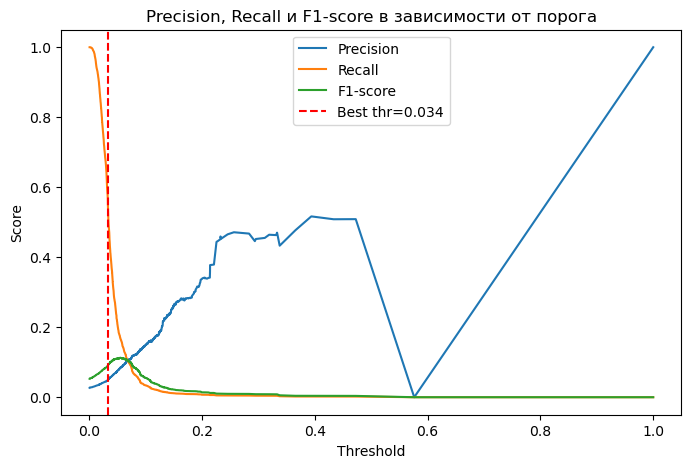

Лучший порог: 0.0344, Precision=0.052, Recall=0.501, F1=0.093


In [64]:
best_thr, p, r, f1 = find_best_threshold(y_test, y_pred_proba_lgb, min_recall=0.5)
print(f"Лучший порог: {best_thr:.4f}, Precision={p:.3f}, Recall={r:.3f}, F1={f1:.3f}")

In [65]:
y_pred_lgb = (y_pred_proba_lgb >= best_thr).astype(int)

In [66]:
#Главные метрики модели с измененным порогом
print(f"LightLGB — ROC-AUC: {roc_auc:.4f}")
print(classification_report(y_test, y_pred_lgb))

LightLGB — ROC-AUC: 0.6936
              precision    recall  f1-score   support

         0.0       0.98      0.74      0.85    542904
         1.0       0.05      0.50      0.09     15109

    accuracy                           0.74    558013
   macro avg       0.52      0.62      0.47    558013
weighted avg       0.96      0.74      0.83    558013



## Baseline

In [67]:
df_raw = pd.read_csv("data/ga_sessions.csv")

C:\Users\Alexandra\AppData\Local\Temp\ipykernel_23508\980139229.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv("data/ga_sessions.csv")


In [68]:
df_hits = pd.read_csv("data/ga_hits-001.csv")

In [69]:
#Целевое действие
target_actions = [
    'sub_car_claim_click',
    'sub_car_claim_submit_click',
    'sub_open_dialog_click',
    'sub_custom_question_submit_click',
    'sub_call_number_click',
    'sub_callback_submit_click',
    'sub_submit_success',
    'sub_car_request_submit_click'
]

df_hits["event_value"] = df_hits["event_action"].isin(target_actions).astype(int)

In [70]:
#Добавление целевой переменной
target = df_hits.groupby("session_id")["event_value"].max().reset_index()
df_raw = df_raw.merge(target, on="session_id", how="left").fillna({"event_value": 0})

In [71]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1860042 entries, 0 to 1860041
Data columns (total 19 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   session_id                object 
 1   client_id                 object 
 2   visit_date                object 
 3   visit_time                object 
 4   visit_number              int64  
 5   utm_source                object 
 6   utm_medium                object 
 7   utm_campaign              object 
 8   utm_adcontent             object 
 9   utm_keyword               object 
 10  device_category           object 
 11  device_os                 object 
 12  device_brand              object 
 13  device_model              object 
 14  device_screen_resolution  object 
 15  device_browser            object 
 16  geo_country               object 
 17  geo_city                  object 
 18  event_value               float64
dtypes: float64(1), int64(1), object(17)
memory usage: 269.6+ MB


In [72]:
df_raw.nunique()

session_id                  1860042
client_id                   1391717
visit_date                      226
visit_time                    85318
visit_number                    537
utm_source                      293
utm_medium                       56
utm_campaign                    412
utm_adcontent                   286
utm_keyword                    1219
device_category                   3
device_os                        13
device_brand                    205
device_model                    104
device_screen_resolution       5039
device_browser                   57
geo_country                     166
geo_city                       2548
event_value                       2
dtype: int64

In [73]:
missing_values = (df_raw.isna().sum()/len(df_raw)*100).sort_values(ascending=False)
print('Процент пропущенных значений:')
missing_values

Процент пропущенных значений:


device_model                99.121633
utm_keyword                 58.174009
device_os                   57.533002
device_brand                19.740307
utm_adcontent               18.043410
utm_campaign                11.806346
utm_source                   0.005215
geo_city                     0.000000
geo_country                  0.000000
device_browser               0.000000
device_screen_resolution     0.000000
session_id                   0.000000
device_category              0.000000
client_id                    0.000000
utm_medium                   0.000000
visit_number                 0.000000
visit_time                   0.000000
visit_date                   0.000000
event_value                  0.000000
dtype: float64

Все пропуски заполним просто missing, колонки с большим количеством уникальных значений закодируем LabelEncoder, остальные OneHotEncoder

In [74]:
#Колонки для кодирования LabelEncoder
cols_to_encode_label = [
    "utm_source", "utm_campaign",
    "utm_adcontent", "utm_keyword", "device_brand", "geo_city"
]

for col in cols_to_encode_label:
    le = LabelEncoder()
    df_raw[col] = df_raw[col].astype(str).fillna("missing")  # заменим NaN на строку "missing"
    df_raw[col] = le.fit_transform(df_raw[col])


In [75]:
#Колонки для кодирования OneHotEncoder
cols_to_encode_onehot = ["device_category", "device_os", "device_browser", "utm_medium", "geo_country"]
df_raw[cols_to_encode_onehot] = df_raw[cols_to_encode_onehot].fillna('missing')

In [76]:
ohe = OneHotEncoder(sparse_output = False) 

In [77]:
ohe_categories = ohe.fit_transform(df_raw[cols_to_encode_onehot])

In [78]:
# Делаем DataFrame с новыми колонками
ohe_df = pd.DataFrame(ohe_categories, columns=ohe.get_feature_names_out(cols_to_encode_onehot), index=df_raw.index)
# Склеиваем с исходным датафреймом
df_raw = pd.concat([df_raw, ohe_df], axis=1)

In [79]:
#Колонки для удаления
cols_to_drop = ['session_id', 'client_id','visit_number', 'visit_date', 'visit_time',
                'utm_medium','device_category', 'device_os', 'device_model',
                'device_screen_resolution', 'device_browser', 'geo_country']
df_raw = df_raw.drop(cols_to_drop, axis = 1)

In [80]:
pd.set_option("display.max_columns", None)
df_raw.head()

,utm_source,utm_campaign,utm_adcontent,utm_keyword,device_brand,geo_city,event_value,device_category_desktop,device_category_mobile,device_category_tablet,device_os_(not set),device_os_Android,device_os_BlackBerry,device_os_Chrome OS,device_os_Firefox OS,device_os_Linux,device_os_Macintosh,device_os_Nokia,device_os_Samsung,device_os_Tizen,device_os_Windows,device_os_Windows Phone,device_os_iOS,device_os_missing,device_browser_(not set),device_browser_Amazon Silk,device_browser_Android,device_browser_Android Browser,device_browser_Android Runtime,device_browser_Android Webview,device_browser_Chrome,device_browser_Coc Coc,device_browser_Edge,device_browser_Firefox,device_browser_Instagram 158.0.0.30.123 Android,device_browser_Instagram 192.0.0.35.123 Android,device_browser_Instagram 192.0.0.37.119,device_browser_Instagram 194.0.0.36.172 Android,device_browser_Instagram 199.0.0.27.120,device_browser_Instagram 199.1.0.34.119 Android,device_browser_Instagram 201.0.0.23.111,device_browser_Instagram 202.0.0.23.119,device_browser_Instagram 202.0.0.37.123 Android,device_browser_Instagram 203.0.0.26.117,device_browser_Instagram 206.1.0.34.121 Android,device_browser_Instagram 207.0.0.28.118,device_browser_Instagram 208.0.0.26.131,device_browser_Instagram 208.0.0.32.135 Android,device_browser_Instagram 209.0.0.21.119 Android,device_browser_Instagram 212.0.0.38.119 Android,device_browser_Instagram 213.0.0.19.117,device_browser_Instagram 213.0.0.29.120 Android,device_browser_Instagram 216.0.0.12.135,device_browser_Instagram 216.1.0.21.137 Android,device_browser_Internet Explorer,device_browser_Iron,device_browser_Konqueror,device_browser_MRCHROME,device_browser_MT6735_TD,device_browser_Maxthon,device_browser_Mozilla,device_browser_Mozilla Compatible Agent,device_browser_MyApp,device_browser_NetFront,device_browser_Nokia501,device_browser_NokiaX2-02,device_browser_Opera,device_browser_Opera Mini,device_browser_Phantom Browser,device_browser_Puffin,device_browser_Safari,device_browser_Safari (in-app),device_browser_Samsung Internet,device_browser_SeaMonkey,device_browser_Threads 202.0.0.23.119,device_browser_UC Browser,device_browser_YaBrowser,device_browser_[FBAN,device_browser_com.vk.vkclient,device_browser_com.zhiliaoapp.musically,device_browser_helloworld,utm_medium_(none),utm_medium_(not set),utm_medium_CPM,utm_medium_Sbol_catalog,utm_medium_app,utm_medium_article,utm_medium_banner,utm_medium_blogger_channel,utm_medium_blogger_header,utm_medium_blogger_stories,utm_medium_catalogue,utm_medium_cbaafe,utm_medium_clicks,utm_medium_cpa,utm_medium_cpc,utm_medium_cpm,utm_medium_cpv,utm_medium_desktop,utm_medium_dom_click,utm_medium_email,utm_medium_fb_smm,utm_medium_google_cpc,utm_medium_info_text,utm_medium_landing,utm_medium_landing_interests,utm_medium_last,utm_medium_link,utm_medium_linktest,utm_medium_main_polka,utm_medium_medium,utm_medium_nkp,utm_medium_ok_smm,utm_medium_organic,utm_medium_outlook,utm_medium_partner,utm_medium_post,utm_medium_promo_sber,utm_medium_promo_sbol,utm_medium_push,utm_medium_qr,utm_medium_qrcodevideo,utm_medium_reach,utm_medium_referral,utm_medium_sber_app,utm_medium_smartbanner,utm_medium_smm,utm_medium_sms,utm_medium_social,utm_medium_static,utm_medium_stories,utm_medium_tablet,utm_medium_tg,utm_medium_users_msk,utm_medium_vk_smm,utm_medium_web_polka,utm_medium_yandex_cpc,geo_country_(not set),geo_country_Afghanistan,geo_country_Albania,geo_country_Algeria,geo_country_Andorra,geo_country_Angola,geo_country_Antigua & Barbuda,geo_country_Argentina,geo_country_Armenia,geo_country_Aruba,geo_country_Australia,geo_country_Austria,geo_country_Azerbaijan,geo_country_Bahrain,geo_country_Bangladesh,geo_country_Barbados,geo_country_Belarus,geo_country_Belgium,geo_country_Bosnia & Herzegovina,geo_country_Brazil,geo_country_Bulgaria,geo_country_Burkina Faso,geo_country_Burundi,geo_country_Cambodia,geo_country_Cameroon,geo_country_Canada,geo_country_Central African Republic,geo_country_Chad,geo_country_Chile,geo_country_Ch

In [81]:
#Разбиение датасета на train и test

x = df_raw.drop(['event_value'], axis=1)
y = df_raw['event_value']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [82]:
lr = LogisticRegression()

In [83]:
lr.fit(x_train, y_train)

C:\Users\Alexandra\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [84]:
#Метрика ROC-AUC
y_proba_raw = lr.predict_proba(x_test)[:, 1]
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba_raw):.4f}")

ROC-AUC: 0.6150


Качественное заполнение пропусков, работа с выбросами и аномалиями, генерация новых фич, а также обоснованный выбор модели и тюнинг помогли увеличить метрику roc-auc с 0.61 до 0.69, что составляет примерно 13%